In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
# 1. Memuat Data
data = pd.read_csv('dataset/Train.csv')

In [25]:
# 2. Eksplorasi Data
print("Informasi Data:")
print(data.info())

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


In [26]:
print("\nLima Baris Pertama Data:")
print(data.head())


Lima Baris Pertama Data:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44 

In [27]:
# Memeriksa distribusi variabel target
print("\nDistribusi Variabel Target:")
print(data['Reached.on.Time_Y.N'].value_counts(normalize=True))


Distribusi Variabel Target:
Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


# 3. Pra-pemrosesan Data

In [28]:
# Menghapus kolom ID karena tidak relevan
data = data.drop('ID', axis=1)

In [29]:
# Memastikan kolom ID ada sebelum menghapusnya
if 'ID' in data.columns:
    data = data.drop('ID', axis=1)
else:
    print("Kolom 'ID' tidak ditemukan di dataset.")


Kolom 'ID' tidak ditemukan di dataset.


In [30]:
# Mengonversi variabel kategori menjadi numerik menggunakan LabelEncoder
label_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
label_encoders = {col: LabelEncoder().fit(data[col]) for col in label_cols}
for col in label_cols:
    data[col] = label_encoders[col].transform(data[col])

In [31]:
# Pisahkan fitur dan target
X = data.drop('Reached.on.Time_Y.N', axis=1)
y = data['Reached.on.Time_Y.N']

In [32]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Split dataset menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 4. Baseline Model - Random Forest Classifier

In [34]:
# Inisialisasi model
rf_model = RandomForestClassifier(random_state=42)

In [35]:
# Melakukan training model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Prediksi pada test set
y_pred_rf = rf_model.predict(X_test)

In [37]:
# Evaluasi Model Random Forest
print("\nConfusion Matrix - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))


Confusion Matrix - Random Forest:
[[650 237]
 [498 815]]


In [38]:
print("\nClassification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))


Classification Report - Random Forest:
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       887
           1       0.77      0.62      0.69      1313

    accuracy                           0.67      2200
   macro avg       0.67      0.68      0.66      2200
weighted avg       0.69      0.67      0.67      2200



In [39]:
print("\nAccuracy Score - Random Forest:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC Score - Random Forest:", roc_auc_score(y_test, y_pred_rf))


Accuracy Score - Random Forest: 0.6659090909090909
ROC AUC Score - Random Forest: 0.6767615665391012


# 6. Model Lebih Kompleks - Gradient Boosting Classifier

In [40]:
# Inisialisasi model Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)

In [41]:
# Set hyperparameter yang ingin diuji
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [42]:
# Grid Search untuk hyperparameter tuning
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=2)

In [43]:
# Mendapatkan model terbaik dan menampilkan hyperparameters terbaik
best_model = grid_search.best_estimator_
print("Hyperparameters terbaik:", grid_search.best_params_)

Hyperparameters terbaik: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [44]:
# Menggunakan model terbaik untuk prediksi pada test set
y_pred_best = best_model.predict(X_test)

In [45]:
# Evaluasi model terbaik
print("\nConfusion Matrix - Gradient Boosting:")
print(confusion_matrix(y_test, y_pred_best))


Confusion Matrix - Gradient Boosting:
[[752 135]
 [587 726]]


In [46]:
print("\nClassification Report - Gradient Boosting:")
print(classification_report(y_test, y_pred_best))


Classification Report - Gradient Boosting:
              precision    recall  f1-score   support

           0       0.56      0.85      0.68       887
           1       0.84      0.55      0.67      1313

    accuracy                           0.67      2200
   macro avg       0.70      0.70      0.67      2200
weighted avg       0.73      0.67      0.67      2200



In [47]:
print("\nAccuracy Score - Gradient Boosting:", accuracy_score(y_test, y_pred_best))
print("ROC AUC Score - Gradient Boosting:", roc_auc_score(y_test, y_pred_best))


Accuracy Score - Gradient Boosting: 0.6718181818181819
ROC AUC Score - Gradient Boosting: 0.7003668973262777


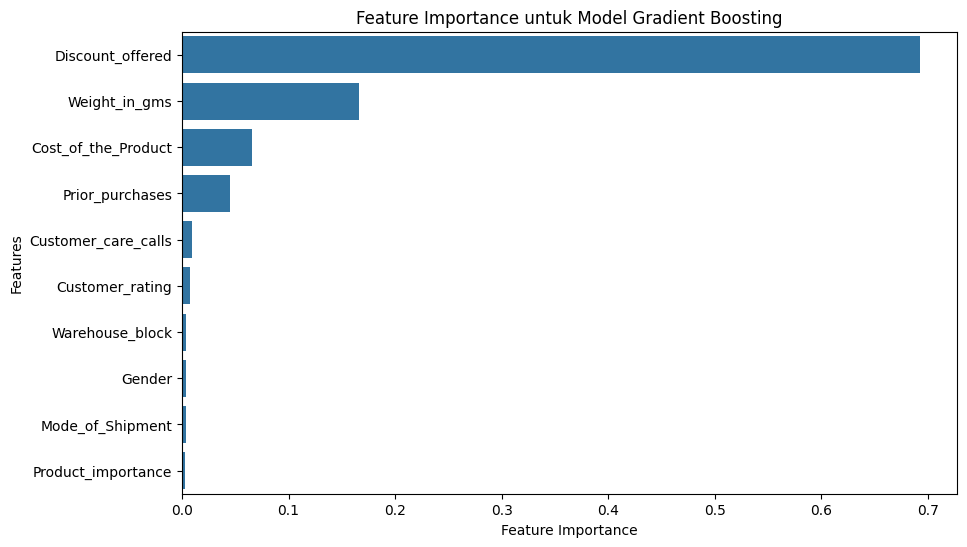

In [48]:
# 7. Visualisasi Feature Importance
feature_importance = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance untuk Model Gradient Boosting')
plt.show()